In [1]:
import numpy as np
import mylibrary.nnlib as tnn
import matplotlib.pyplot as plt
import copy

from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn

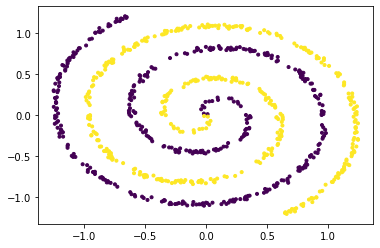

In [2]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

x, y = twospirals(400)
x, y = x/10, y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.scatter(x1, x2, c=y, marker='.')
plt.show()

In [3]:
net = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Linear(5, 1),
    nn.Sigmoid()
)

In [4]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.003)
criterion = nn.BCELoss()

In [5]:
%matplotlib tk
fig = plt.figure()
ax = fig.gca()

try:
    for epoch in range(100000):
        yout = net(xx)
        
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch%100 == 0:
            error = float(loss)
            print(epoch, 'Error = ', error)
            ax.clear()

            out = yout.data.numpy().reshape(-1) > 0.5
            ax.scatter(x1, x2, c=out, marker='.')
            ax.set_xlabel('X1')
            ax.set_ylabel('X2')

            fig.canvas.draw()
            plt.pause(0.01)
    
except Exception as e:
    plt.close()
    if str(e).startswith('invalid command name'):
        print("Closing Tk Plot ")
    else:
        raise e

0 Error =  0.708151638507843
100 Error =  0.6838323473930359
200 Error =  0.6360735893249512
300 Error =  0.5385273098945618
400 Error =  0.5313301086425781
500 Error =  0.5302335619926453
600 Error =  0.5236403942108154
700 Error =  0.5232580304145813
800 Error =  0.5231806039810181
900 Error =  0.5231456160545349
1000 Error =  0.5231313705444336
1100 Error =  0.5231204032897949
1200 Error =  0.5170266032218933
1300 Error =  0.513258159160614
1400 Error =  0.40758267045021057
1500 Error =  0.18985910713672638
1600 Error =  0.0872369185090065
1700 Error =  0.048616647720336914
1800 Error =  0.034571122378110886
1900 Error =  0.027302291244268417
2000 Error =  0.022410361096262932
2100 Error =  0.018828846514225006
2200 Error =  0.016093876212835312
2300 Error =  0.013957342132925987
2400 Error =  0.01223534345626831
2500 Error =  0.010805713944137096
2600 Error =  0.009601922705769539
2700 Error =  0.008571278303861618
2800 Error =  0.007663687691092491
2900 Error =  0.0069143730215728

In [6]:
list(net._modules.items())

[('0', Linear(in_features=2, out_features=5, bias=True)),
 ('1', ReLU()),
 ('2', Linear(in_features=5, out_features=10, bias=True)),
 ('3', ReLU()),
 ('4', Linear(in_features=10, out_features=10, bias=True)),
 ('5', ReLU()),
 ('6', Linear(in_features=10, out_features=5, bias=True)),
 ('7', ReLU()),
 ('8', Linear(in_features=5, out_features=1, bias=True)),
 ('9', Sigmoid())]

## Oracle Pruning

In [7]:
class Oracle():
    
    def __init__(self, net):
        self.net = net
        self.activations = {}
        self.gradients = {}
        self.forward_hook = {}
        self.backward_hook = {}
        self.keys = []
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_backward_hook(self.capture_gradients)
                self.backward_hook[module] = hook
                hook = module.register_forward_hook(self.capture_inputs)
                self.forward_hook[module] = hook
                
                self.activations[module] = None
                self.gradients[module] = None
                self.keys.append(module)
        pass
            
        
    def capture_inputs(self, module, inp, out):
#         print(out.shape)
        self.activations[module] = out.data
        
    def capture_gradients(self, module, gradi, grado):
#         print("Grad")
#         print(gradi[-1])
#         for gi in gradi:
#             print(gi.shape)
#         print(grado)
#         print(grado[0].shape)
        self.gradients[module] = grado[0]
        
    def gather_inputs_gradients(self, x, t):
        self.net.zero_grad()
        y = self.net(x)
        
        error = criterion(y,t)
        error.backward()
        
        for module in self.keys:
            hook = self.forward_hook[module]
            hook.remove()
            hook = self.backward_hook[module]
            hook.remove()
        return
    
    def compute_significance(self, x, t):
        self.gather_inputs_gradients(x, t)
        
        ## compute importance score
        importance = []
        for module in self.keys:
            z = self.activations[module] * self.gradients[module]
            z = z.mean(dim=0).abs()
            importance.append(z)
            
        return importance

In [8]:
oracle = Oracle(net)
oracle.compute_significance(xx, yy)

[tensor([4.4805e-07, 1.3688e-07, 3.3705e-07, 2.8434e-07, 0.0000e+00]),
 tensor([2.6992e-07, 4.8907e-08, 2.4949e-08, 0.0000e+00, 1.0904e-08, 1.1832e-08,
         2.8462e-09, 1.9499e-07, 7.2042e-08, 3.3846e-09]),
 tensor([1.6882e-08, 0.0000e+00, 1.5246e-07, 1.5481e-07, 4.5873e-08, 1.3686e-07,
         1.2072e-08, 2.7227e-07, 7.6243e-09, 0.0000e+00]),
 tensor([1.4424e-07, 2.9524e-07, 9.3686e-09, 1.1892e-08, 1.1889e-08]),
 tensor([1.5229e-05])]

In [9]:
class Oracle_Modified():
    
    def __init__(self, net, mode="oracle"):
        self.net = net
        self.mode = mode
        
        self.activations = {}
        self.gradients = {}
        self.forward_hook = {}
        self.backward_hook = {}
        self.keys = []
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_backward_hook(self.capture_gradients)
                self.backward_hook[module] = hook
                hook = module.register_forward_hook(self.capture_inputs)
                self.forward_hook[module] = hook
                
                self.activations[module] = None
                self.gradients[module] = None
                self.keys.append(module)
        
#         self.importance = None
        pass
            
        
    def capture_inputs(self, module, inp, out):
        self.activations[module] = out.data
        
    def capture_gradients(self, module, gradi, grado):
        self.gradients[module] = grado[0]
        
    def gather_inputs_gradients(self, x, t):
        self.net.zero_grad()
        y = self.net(x)
        
        error = criterion(y, t)
        error.backward()
        
        for module in self.keys:
            hook = self.forward_hook[module]
            hook.remove()
            hook = self.backward_hook[module]
            hook.remove()
        return
    
    def compute_significance(self, x, t, mode=None, normalize=False):
        self.gather_inputs_gradients(x, t)
        
        if mode is None:
            mode = self.mode
        
        ## compute importance score
        importance = []
        if mode == "oracle":
            for module in self.keys:
                z = self.activations[module] * self.gradients[module]
                z = z.sum(dim=0).abs()
                importance.append(z)

        elif mode == "oracle_absolute":
            for module in self.keys:
                z = (self.activations[module] * self.gradients[module])
                z = z.abs().sum(dim=0)
                importance.append(z)
        
        elif mode == "oracle_normalized":
            scaler = torch.norm(self.gradients[self.keys[-1]], dim=1, keepdim=True) + 1e-5
#             print(scaler.shape)
            for module in self.keys:
                z = (self.activations[module] * self.gradients[module])/scaler
                z = z.sum(dim=0).abs()
                importance.append(z)
                                
        elif mode == "oracle_abs_norm":
            scaler = torch.norm(self.gradients[self.keys[-1]], p=2, dim=1, keepdim=True) + 1e-5
#             print(scaler)
            for module in self.keys:
                z = (self.activations[module] * self.gradients[module])/scaler
                z = z.abs().sum(dim=0)
                importance.append(z)               
        
        importance = importance[:-1]
        if normalize:
            sums = 0
            count = 0
            for imp in importance:
                sums += imp.sum()
                count += len(imp)
#             print(sums, count)
            divider = sums/count ## total importance is number of neurons
            for i in range(len(importance)):
                importance[i] = importance[i]/divider
            
        return importance

In [10]:
oracle_mod = Oracle_Modified(net)

In [11]:
modes = ["oracle", "oracle_absolute", "oracle_normalized", "oracle_abs_norm"]

In [12]:
oracle_mod.compute_significance(xx, yy, mode=modes[0], normalize=True)

[tensor([4.3115, 1.3172, 3.2434, 2.7362, 0.0000]),
 tensor([2.5974, 0.4706, 0.2401, 0.0000, 0.1049, 0.1139, 0.0274, 1.8764, 0.6933,
         0.0326]),
 tensor([0.1624, 0.0000, 1.4671, 1.4897, 0.4414, 1.3170, 0.1162, 2.6200, 0.0734,
         0.0000]),
 tensor([1.3880, 2.8410, 0.0902, 0.1144, 0.1144])]

In [13]:
oracle_mod.compute_significance(xx, yy, mode=modes[1], normalize=True)

[tensor([1.7993, 0.1203, 7.1521, 0.2040, 0.0000]),
 tensor([2.2194e-01, 4.4837e+00, 9.2215e-02, 0.0000e+00, 3.4857e+00, 8.2443e-03,
         2.2223e+00, 1.3174e+00, 5.5606e-02, 2.3583e-03]),
 tensor([0.0118, 0.0000, 0.6854, 2.0698, 0.1539, 4.1091, 0.0084, 1.3924, 0.0053,
         0.0000]),
 tensor([0.1005, 0.2753, 0.0065, 0.0083, 0.0083])]

In [14]:
oracle_mod.compute_significance(xx, yy, mode=modes[2], normalize=False)

[tensor([ 6.6034, 10.7578,  5.2661, 22.0414,  0.0000]),
 tensor([15.8295, 17.5895,  1.8627,  0.0000, 11.6590,  0.9106,  7.9573,  7.1050,
          5.6746,  0.2703]),
 tensor([ 1.3252,  0.0000, 12.5920,  2.2242,  3.7268, 20.7492,  0.9504, 11.6263,
          0.6063,  0.0000]),
 tensor([ 9.5122, 10.0878,  0.7402,  0.9395,  0.9393])]

In [15]:
oracle_mod.compute_significance(xx, yy, mode=modes[3], normalize=True)

[tensor([2.1349, 0.3124, 6.3014, 0.5212, 0.0000]),
 tensor([0.4501, 4.4663, 0.2369, 0.0000, 3.1755, 0.0209, 2.0200, 1.3359, 0.1444,
         0.0062]),
 tensor([0.0304, 0.0000, 0.7174, 1.7091, 0.3978, 3.5956, 0.0218, 1.8263, 0.0139,
         0.0000]),
 tensor([0.2183, 0.2830, 0.0170, 0.0216, 0.0216])]

## Get pruning mask

In [16]:
def get_pruning_mask(importance, output_dim, num_prune=1):
    layer_dims = []
    for imp in importance:
        layer_dims.append(len(imp))
    
    imps = torch.ones(len(imp), max(layer_dims))*sum(layer_dims)*10
    imps_shape = imps.shape
    for i, imp in enumerate(importance):
        imps[i, :len(imp)] = imp
        
#     print(imps)
    imps = imps.reshape(-1)
    indices = torch.argsort(imps)
#     print(indices)
    imps[indices[:num_prune]] = -1.
    imps = imps.reshape(imps_shape)
    
    mask = (imps>=0).type(torch.float)
    masks = []
    for i, imp in enumerate(importance):
        masks.append(mask[i, :len(imp)])
    return masks

In [17]:
# importance = oracle_mod.compute_significance(xx, yy, mode=modes[3], normalize=True)
# importance

In [18]:
# get_pruning_mask(importance, 1, num_prune=7)

In [19]:
importance = oracle_mod.compute_significance(xx, yy, mode=modes[0], normalize=True)
get_pruning_mask(importance, 1, num_prune=7)

[tensor([1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 1., 1., 1., 1.])]

In [20]:
importance = oracle_mod.compute_significance(xx, yy, mode=modes[1], normalize=True)
get_pruning_mask(importance, 1, num_prune=7)

[tensor([1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 1., 0., 1., 1.])]

In [21]:
importance = oracle_mod.compute_significance(xx, yy, mode=modes[2], normalize=True)
get_pruning_mask(importance, 1, num_prune=7)

[tensor([1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 1., 0., 1., 1.])]

In [22]:
importance = oracle_mod.compute_significance(xx, yy, mode=modes[3], normalize=True)
get_pruning_mask(importance, 1, num_prune=7)

[tensor([1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 1., 0., 1., 1.])]

## Define pruning function

In [23]:
class Pruner():
    
    def __init__(self, net, prune_mask=None):
        self.net = net
        self.keys = []
        self.prune_mask = {}
        self.forward_hook = {}
        
        self.activations = []
        
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                self.keys.append(module)

        if prune_mask is not None:
            self.add_prune_mask(prune_mask)
        self.remove_hook()
        
    def add_prune_mask(self, prune_mask):
        for module, pm in zip(self.keys[:-1], prune_mask):
            self.prune_mask[module] = pm.type(torch.float)
        self.prune_mask[self.keys[-1]] = torch.ones(self.keys[-1].out_features, dtype=torch.float)
            
        
    def prune_neurons(self, module, inp, out):
        mask = self.prune_mask[module]
        output = out*mask
        
        self.activations.append(output)
        return output
        
    def forward(self, x, prune_mask=None):
        if prune_mask:
            self.add_prune_mask(prune_mask)
            if len(self.forward_hook) == 0:
                self.add_hook()
        
        y = self.net(x)
        self.remove_hook()
        return y
        
        
    def add_hook(self):
        if len(self.forward_hook) > 0:
            self.remove_hook()
            
        self.forward_hook = {}
        for name, module in list(self.net._modules.items()):
            if isinstance(module, torch.nn.Linear):
                hook = module.register_forward_hook(self.prune_neurons)
                self.forward_hook[module] = hook
        return
        
    def remove_hook(self):       
        for module in self.forward_hook.keys():
            hook = self.forward_hook[module]
            hook.remove()
        self.forward_hook = {}
        return

In [24]:
importance = oracle_mod.compute_significance(xx, yy, mode=modes[0], normalize=True)
pmask = get_pruning_mask(importance, 1, num_prune=7)

In [25]:
importance

[tensor([4.3115, 1.3172, 3.2434, 2.7362, 0.0000]),
 tensor([2.5974, 0.4706, 0.2401, 0.0000, 0.1049, 0.1139, 0.0274, 1.8764, 0.6933,
         0.0326]),
 tensor([0.1624, 0.0000, 1.4671, 1.4897, 0.4414, 1.3170, 0.1162, 2.6200, 0.0734,
         0.0000]),
 tensor([1.3880, 2.8410, 0.0902, 0.1144, 0.1144])]

In [26]:
pmask

[tensor([1., 1., 1., 1., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 0., 1., 1., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 1., 1., 0., 0.]),
 tensor([1., 1., 1., 1., 1.])]

In [27]:
pnet = Pruner(net, pmask)

In [28]:
yout_normal = net.forward(xx).data.cpu()
yout_prune = pnet.forward(xx).data.cpu()

In [29]:
yout_normal.shape, yout_prune.shape

(torch.Size([800, 1]), torch.Size([800, 1]))

In [35]:
criterion(yout_normal, yy), criterion(yout_prune, yy)

(tensor(0.0023), tensor(1.6571))

In [31]:
((yout_prune-yout_normal)**2).mean()

tensor(0.)

## comparing for all

In [37]:
num = 15
pnet = Pruner(net)

yout_normal = net.forward(xx).data.cpu()
print("loss is ", float(criterion(yout_normal, yy)))
for i in range(4):
    print(modes[i])
    importance = oracle_mod.compute_significance(xx, yy, mode=modes[i], normalize=True)
    pmask = get_pruning_mask(importance, 1, num_prune=num)

    for pm in pmask:
        print(pm)
    
    yout_prune = pnet.forward(xx, prune_mask=pmask).data.cpu()
    new_err = criterion(yout_prune, yy)
    print("new error = ", float(new_err))
    
    deviation = ((yout_prune-yout_normal)**2).mean()
    print("deviation = ", float(deviation))

loss is  0.0022599201183766127
oracle
tensor([1., 1., 1., 1., 0.])
tensor([1., 1., 0., 0., 0., 0., 0., 1., 1., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([1., 1., 0., 0., 0.])
new error =  10.14507007598877
deviation =  0.5432661175727844
oracle_absolute
tensor([1., 1., 1., 1., 0.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 0.])
new error =  2.485715627670288
deviation =  0.4534703493118286
oracle_normalized
tensor([1., 1., 1., 1., 0.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 1., 0.])
tensor([0., 0., 1., 0., 0., 1., 0., 1., 0., 0.])
tensor([1., 1., 0., 0., 0.])
new error =  37.25972366333008
deviation =  0.4367658495903015
oracle_abs_norm
tensor([1., 1., 1., 1., 0.])
tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0.])
tensor([0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])
tensor([0., 1., 0., 0., 0.])
new error =  2.485715627670288
deviation =  0.4534703493118286


In [34]:
pnet.keys

[Linear(in_features=2, out_features=5, bias=True),
 Linear(in_features=5, out_features=10, bias=True),
 Linear(in_features=10, out_features=10, bias=True),
 Linear(in_features=10, out_features=5, bias=True),
 Linear(in_features=5, out_features=1, bias=True)]